# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

**Цель исследования**: Построить модель для определения стоимости автомобилей с лучшими характеристиками качества и скорости предсказания, времени обучения модели.

**Исходные данные**: Исторические данные (технические характеристики, комплектации и цены автомобилей). 


    Признаки
    
    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
    Целевой признак
    
    Price — цена (евро)
 
**Задачи исследования**:

1. Подготовить данные 
2. Обучить 3 модели 
3. Проанализировать качество моделей, выбрать лучшую модель 
4. Общий вывод
    

    



## Подготовка данных

Импортируем  и установим необходимые библиотеки:

In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

Откроем таблицу с данными:

In [4]:
try:
    data = pd.read_csv('C:\\Users\\vasil\\Downloads\\Chislennye_metody\\autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')
    
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

C:\Users\vasil\AppData\Local\Temp/ipykernel_10768/2554096034.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [6]:
#Удалим из таблицы столбцы, которые не потребуются для построения модели 
data.drop(columns=['date_crawled', 'registration_month', 'date_created','postal_code', 'last_seen'], inplace=True)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,number_of_pictures
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0


In [7]:
data['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [8]:
#Исключим нулевые значения цены 
data = data.query('price != 0')

In [9]:
data.query('0 <= price <= 10')['price'].value_counts()

1     1189
10      84
5       26
2       12
8        9
3        8
9        8
7        3
4        1
Name: price, dtype: int64

In [10]:
#Сделаем срез 
data = data.query('price > 10')

In [11]:
#Проверим таблицу на наличие пропусков 
data.isna().mean()

price                 0.000000
vehicle_type          0.097009
registration_year     0.000000
gearbox               0.049384
power                 0.000000
model                 0.050345
kilometer             0.000000
fuel_type             0.084562
brand                 0.000000
not_repaired          0.190284
number_of_pictures    0.000000
dtype: float64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342257 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               342257 non-null  int64 
 1   vehicle_type        309055 non-null  object
 2   registration_year   342257 non-null  int64 
 3   gearbox             325355 non-null  object
 4   power               342257 non-null  int64 
 5   model               325026 non-null  object
 6   kilometer           342257 non-null  int64 
 7   fuel_type           313315 non-null  object
 8   brand               342257 non-null  object
 9   not_repaired        277131 non-null  object
 10  number_of_pictures  342257 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 31.3+ MB


Все столбцы имеющие пропуски, явяются категориальными, поэтому пропуски в столбцах  `vehicle_type`, `gearbox`, `model`, `fuel_type `, `not_repaired` заполним новой категорией no data. 

In [13]:
data['vehicle_type'].replace(np.nan, 'no data', inplace = True)
data['gearbox'].replace(np.nan, 'no data', inplace = True)
data['model'].replace(np.nan, 'no data', inplace = True)
data['fuel_type'].replace(np.nan, 'no data', inplace = True)
data['not_repaired'].replace(np.nan, 'no data', inplace = True)

In [14]:
data.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
fuel_type             0
brand                 0
not_repaired          0
number_of_pictures    0
dtype: int64

In [15]:
data.describe()

,price,registration_year,power,kilometer,number_of_pictures
count,342257.000000,342257.000000,342257.000000,342257.000000,342257.0
mean,4572.949184,2004.075700,111.125470,128396.745720,0.0
std,4514.872802,77.264358,188.194035,37407.668003,0.0
min,11.000000,1000.000000,0.000000,5000.000000,0.0
25%,1200.000000,1999.000000,69.000000,125000.000000,0.0
50%,2900.000000,2003.000000,105.000000,150000.000000,0.0
75%,6500.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


In [16]:
# Столбец с количеством фотографий имеет только нулевые значения, исключим его из числа признаков 
data = data.drop(['number_of_pictures'],axis=1)

In [17]:
data = data.drop_duplicates()

In [18]:
data.duplicated().sum()

0

### Исследование данных 

Цена на машины является целевым признаком, поэтому корректировать этот столбец не будем. Рассмотрим распределение цены при помощи графиков. 

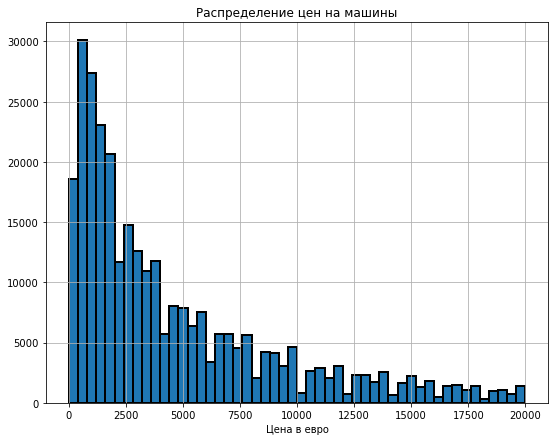

In [19]:
data['price'].hist(bins=50, figsize=(9,7), edgecolor='black', linewidth=2)
plt.title('Распределение цен на машины')
plt.xlabel('Цена в евро')
plt.show()

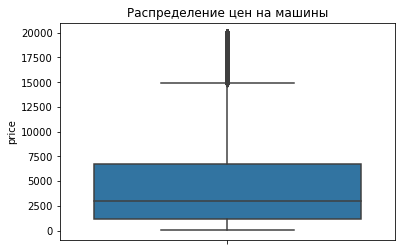

In [20]:
sns.boxplot(y='price',data=data) 
plt.title('Распределение цен на машины')
plt.show()

Проведем анализ количественных признаков на предмет аномалий и редких значений.

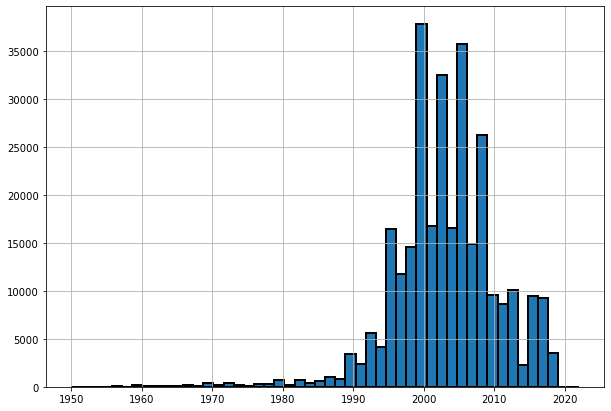

In [21]:
data['registration_year'].hist(bins=50, range=(1950,2022), figsize=(10,7), edgecolor='black', linewidth=2)
plt.show()

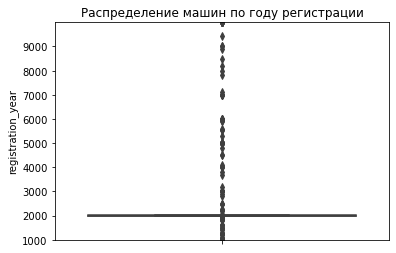

In [22]:
sns.boxplot(y='registration_year',data=data) 
plt.title('Распределение машин по году регистрации')
plt.ylim(1000,9999)
plt.show()

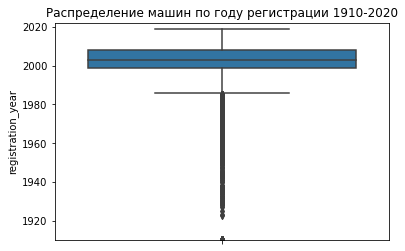

In [23]:
sns.boxplot(y='registration_year',data=data) 
plt.title('Распределение машин по году регистрации 1910-2020')
plt.ylim(1910,2022)
plt.show()

Год регистрации явно имеет аномалии, такие как: минимальное (1000) и максимальное значение (9999). Если срезать сверху мы можем по значению текущего года (2022), то для того чтобы отледить аномалии снизу был построен еще график ящика с усами. Хвост до 1 квартиля достаточно длиный, при том машины зарегистрированные до 1990 являются редкими, вычислим их долю. 

In [24]:
#Доля машин с годом регистрации раньше 1990 года 

data.loc[data['registration_year'] < 1990]['registration_year'].count()/data.loc[data['registration_year'] != 0]['registration_year'].count()

0.028090920332746225

Доля машин с годом регистрации раньше 1990 года меньше 3%. Далее сделаем срез по годам от 1990 до 2016 и сохраним его в новой таблице. 

In [25]:
data_good = data.query('1990 <= registration_year <= 2016')
data_good.shape

(277948, 10)

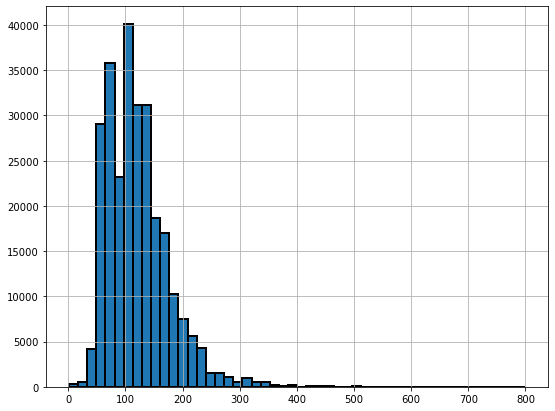

In [26]:
data['power'].hist(bins=50,range=(1,800), figsize=(9,7), edgecolor='black', linewidth=2)
plt.show()

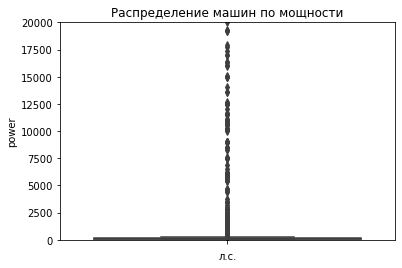

In [27]:
sns.boxplot(y='power',data=data) 
plt.ylim(0,20000)
plt.title('Распределение машин по мощности')
plt.xlabel('л.с.')
plt.show()

В данных есть не точности, часть больших значений заполнена неверно. Посмотрм какие модели имеют значение мощности свыше 1000. 

In [28]:
data.loc[data['power'] > 1000].sort_values(by= 'power').head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,no data
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
307044,1500,sedan,1999,manual,1001,astra,125000,petrol,opel,no
79305,1650,small,2000,auto,1001,a_klasse,150000,petrol,mercedes_benz,no
179821,1100,sedan,1995,manual,1001,a4,150000,no data,audi,no
49724,1500,wagon,2003,manual,1001,focus,150000,gasoline,ford,no data
59887,300,sedan,2004,manual,1002,no data,150000,no data,ford,yes
254594,3990,bus,2003,manual,1003,other,40000,petrol,citroen,no
345756,850,no data,2005,manual,1003,ka,5000,petrol,ford,no
347016,450,sedan,1996,auto,1004,vectra,80000,petrol,opel,yes


В данных опрделенно ошибка, таких значений у этих моделей быть не может. Посмотрим какая доля машим имеет значение более 350л.с.

In [29]:
#Доля машин с мощностью двигателя более 350 л.с. 
data.loc[data['power'] > 350]['power'].count()/data.loc[data['power'] != 0]['power'].count()

0.004089987216446922

In [30]:
data.loc[data['power'] > 350].sort_values(by= 'power').head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
181200,15000,other,1969,manual,351,other,90000,petrol,ford,no
117691,18500,convertible,2007,auto,352,slk,150000,petrol,mercedes_benz,no data
116730,4900,wagon,2002,auto,353,other,150000,petrol,mercedes_benz,no
84354,7000,wagon,2001,auto,354,c_klasse,150000,petrol,mercedes_benz,no
273424,3150,sedan,1999,auto,354,e_klasse,150000,petrol,mercedes_benz,no
268634,8000,sedan,2001,auto,354,e_klasse,150000,petrol,mercedes_benz,no
267088,19300,coupe,2007,manual,354,other,150000,petrol,audi,no
33501,7000,wagon,2000,auto,354,e_klasse,150000,petrol,mercedes_benz,yes
116047,10000,sedan,2000,auto,354,e_klasse,125000,petrol,mercedes_benz,no
218740,8888,wagon,2000,auto,354,e_klasse,150000,lpg,mercedes_benz,no


Теперь информация о мощности двигателя ближе к истине. Так как устранить аномалию, не зная, причины мы не сможем, сделаем срез по мощности до 350 л.с. и потеряем менее 1% данных.

In [31]:
data_good = data_good.query('power <= 350')
data.shape, data_good.shape

((299207, 10), (276945, 10))

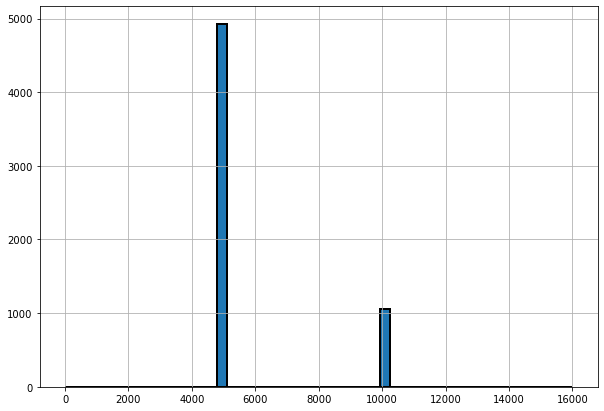

In [32]:
data['kilometer'].hist(bins=50,range=(0,16000), figsize=(10,7), edgecolor='black', linewidth=2)
plt.show()

In [33]:
data['kilometer'].describe()

count    299207.000000
mean     127358.734923
std       38117.717814
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

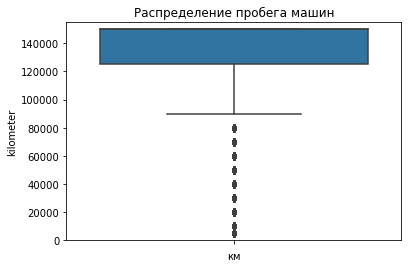

In [34]:
sns.boxplot(y='kilometer',data=data) 
plt.ylim(0,155000)
plt.title('Распределение пробега машин')
plt.xlabel('км')
plt.show()

Распредление значений пробега отличается от всех остальных признаков. У других признаков хвост в сторону больших значений, а в случае пробега длинный хвост редких значений слева, от нуля до значений первого квартиля. И только у этого признака среднее меньше медианы. Но в данном случае не будем исключать редкие значения, так как фактический пробег может быть действительно нулевым или иметь небольшое значение. 

## Обучение моделей

In [35]:
#Разделим данные на обучающую и тестовую выборки
train, test = train_test_split(data_good,train_size=0.6, random_state=42)
train.shape, test.shape

((166167, 10), (110778, 10))

In [36]:
#Разделим тестовую выборкe на валидационную и тестовую 
valid, test = train_test_split(test,train_size=0.5, random_state=42)
valid.shape, test.shape

((55389, 10), (55389, 10))

In [37]:
#Функция оценки качества предсказаний 
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

### CatBoost

Первую модель обучим при помощи библиотеки CatBoost:

In [38]:
train.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

In [39]:
X = ['vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired']
cat_features = ['vehicle_type','gearbox', 'model','fuel_type', 'brand', 'not_repaired']
y = ['price']

In [40]:
%%time

CBR = CatBoostRegressor(cat_features=cat_features, eval_metric='RMSE',random_seed=42,verbose=100)
parameters_CBR = {
               'depth': [6,8,10],
               'learning_rate':[0.4,0.6]
                }
grid_CBR = GridSearchCV(estimator=CBR, param_grid=parameters_CBR, cv=2, n_jobs=-1)

grid_CBR.fit(train[X],train[y],eval_set=(valid[X],valid[y]))

C:\Users\vasil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


0:	learn: 3479.6300536	test: 3480.4242002	best: 3480.4242002 (0)	total: 312ms	remaining: 5m 11s
100:	learn: 1556.3794021	test: 1585.7269335	best: 1585.7269335 (100)	total: 13.9s	remaining: 2m 3s
200:	learn: 1505.8721030	test: 1560.3777911	best: 1560.3777911 (200)	total: 28.2s	remaining: 1m 52s
300:	learn: 1474.6140826	test: 1549.8606167	best: 1549.8606167 (300)	total: 42.5s	remaining: 1m 38s
400:	learn: 1449.3626351	test: 1541.7569434	best: 1541.7375662 (399)	total: 56.7s	remaining: 1m 24s
500:	learn: 1427.5126315	test: 1534.3720290	best: 1534.2632196 (499)	total: 1m 11s	remaining: 1m 10s
600:	learn: 1409.3179532	test: 1531.9414526	best: 1531.8113222 (597)	total: 1m 25s	remaining: 56.8s
700:	learn: 1395.4631372	test: 1530.0594568	best: 1529.8430237 (672)	total: 1m 39s	remaining: 42.6s
800:	learn: 1381.0694650	test: 1528.9672034	best: 1528.9672034 (800)	total: 1m 54s	remaining: 28.5s
900:	learn: 1368.5519739	test: 1528.3814800	best: 1528.3479687 (899)	total: 2m 9s	remaining: 14.2s
999:	

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000189889046D0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'learning_rate': [0.4, 0.6]})

In [41]:
#Лучшие параметры
grid_CBR.best_params_

{'depth': 6, 'learning_rate': 0.4}

In [42]:
%%time
valid_price_pred_CBR = grid_CBR.predict(valid[X])

Wall time: 314 ms


In [43]:
#Проверим качество предсказаний  первой модели на тестовой выборке
rmse_grid_CBR = rmse(valid[y],valid_price_pred_CBR)
rmse_grid_CBR

1526.97

In [44]:
time_predict_grid_CBR = '308 ms'
time_learning_grid_CBR = '14min 42s'

### LightGBM и линейная регрессия 

Для обучения двух следующих моделей необходимо дополнить подготовку данных преобразованием категориальных признаков и масштабирование их. CatBoost преобразовывает категориальные признаки, поэтому для обучения ему отдаем неизменный датасет. Для обучения моделей линейной регрессии и бустинга LGBMRegressor будем использовать новый датасет с преобразованиями.

In [45]:
#Преобразуем категориальные признаки

encoder = OrdinalEncoder()
encoder.fit(data_good)
data_good_ordinal = encoder.transform(data_good) 
data_good_ordinal = pd.DataFrame(encoder.transform(data_good), columns=data_good.columns) 
data_good_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,244.0,3.0,3.0,1.0,0.0,116.0,12.0,7.0,38.0,1.0
1,3495.0,2.0,21.0,1.0,189.0,161.0,11.0,2.0,1.0,2.0
2,2516.0,7.0,14.0,0.0,162.0,117.0,11.0,2.0,14.0,1.0
3,678.0,6.0,11.0,1.0,74.0,116.0,12.0,7.0,38.0,0.0
4,1290.0,6.0,18.0,1.0,68.0,101.0,9.0,2.0,31.0,0.0


In [46]:
#Разделим выборки
train_X, test_X, train_Y, test_Y = train_test_split(data_good_ordinal.drop('price', axis = 1), data_good['price'],
                                             test_size = 0.6, random_state = 42)
train_X.shape, test_X.shape

((110778, 9), (166167, 9))

In [47]:
valid_X, test_X, valid_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.5, random_state = 42)

valid_X.shape, test_X.shape

((83083, 9), (83084, 9))

In [48]:
#Масштабируем количественные признакми 

numeric=['registration_year', 'power', 'kilometer']
scaler=StandardScaler()
scaler.fit(data_good_ordinal[numeric])


train_X[numeric]=scaler.transform(train_X[numeric])
valid_X[numeric]=scaler.transform(valid_X[numeric])
test_X[numeric]=scaler.transform(test_X[numeric])

train_X.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
32082,6.0,1.706273,1.0,-0.663373,167.0,-0.984989,7.0,24.0,0.0
17277,0.0,-0.758902,1.0,0.095903,247.0,0.513236,4.0,24.0,0.0
128753,8.0,0.121518,1.0,-0.316747,167.0,0.513236,2.0,5.0,0.0
255265,5.0,-0.934986,1.0,-0.564337,164.0,0.513236,5.0,31.0,1.0
231481,7.0,0.297602,0.0,0.888191,145.0,0.138680,2.0,20.0,0.0


### LightGBM 

In [49]:
%%time

lgb_R = lgb.sklearn.LGBMRegressor(random_state=42, objective="regression_l2")
parameters_lgb = {
               'depth': [6,8,10],
               'learning_rate':[0.4,0.6],
               'n_estimators':[500,1000]
                }
grid_lgb = GridSearchCV(estimator=lgb_R, param_grid=parameters_lgb, cv=2, n_jobs=-1)

grid_lgb.fit(train_X, train_Y, eval_set=(valid_X, valid_Y), eval_metric='rmse', verbose=100)

C:\Users\vasil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: depth
[100]	valid_0's rmse: 1594.54	valid_0's l2: 2.54255e+06
[200]	valid_0's rmse: 1576.04	valid_0's l2: 2.4839e+06
[300]	valid_0's rmse: 1569.14	valid_0's l2: 2.46221e+06
[400]	valid_0's rmse: 1569.29	valid_0's l2: 2.46269e+06
[500]	valid_0's rmse: 1570.16	valid_0's l2: 2.46541e+06
Wall time: 27.5 s


GridSearchCV(cv=2,
             estimator=LGBMRegressor(objective='regression_l2',
                                     random_state=42),
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'learning_rate': [0.4, 0.6],
                         'n_estimators': [500, 1000]})

In [50]:
#Лучшие параметры
grid_lgb.best_params_

{'depth': 6, 'learning_rate': 0.4, 'n_estimators': 500}

In [51]:
%%time

predict_grid_lgb = grid_lgb.predict(valid_X)

Wall time: 262 ms


In [52]:
#Проверим качество предсказаний второй модели на тестовой выборке
rmse_grid_LGB = rmse(valid_Y, predict_grid_lgb)
rmse_grid_LGB

1570.16

In [53]:
time_predict_grid_LGB = '262 ms'
time_learning_grid_LGB = '27.5 s'

### Линейная регрессия 

In [54]:
#Преобразуем категориальные признаки

data_ohe = pd.get_dummies(data_good, drop_first=True)
data_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_no data,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no data,not_repaired_yes
0,480,1993,0,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#Разделим выборки
trainX, testX, trainY, testY = train_test_split(data_ohe.drop('price', axis = 1), data_good['price'],
                                             test_size = 0.6, random_state = 42)
trainX.shape, testX.shape

((110778, 308), (166167, 308))

In [56]:
validX, testX, validY, testY = train_test_split(testX, testY, test_size = 0.5, random_state = 42)

validX.shape, testX.shape

((83083, 308), (83084, 308))

In [57]:
#Масштабируем количественные признакми 

numeric=['registration_year', 'power', 'kilometer']
scaler=StandardScaler()
scaler.fit(trainX[numeric])


trainX[numeric]=scaler.transform(trainX[numeric])
validX[numeric]=scaler.transform(validX[numeric])
testX[numeric]=scaler.transform(testX[numeric])

trainX.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_no data,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no data,not_repaired_yes
36578,1.705587,-0.659033,-1.277606,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19473,-0.761116,0.096777,0.591064,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153873,0.119849,-0.313990,0.591064,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323562,-0.937309,-0.560450,0.591064,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
290247,0.296042,0.885448,-0.076318,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Обучим модель линейной регрессии

In [58]:
%%time

lr=LinearRegression()
lr.fit(trainX, trainY)
lr_cv = cross_val_score(lr, trainX, trainY, cv=3,scoring='neg_root_mean_squared_error')
rmse_LR = lr_cv[:-1].mean()
lr_cv, rmse_LR

Wall time: 5.04 s


(array([-2.43911984e+03, -2.44063385e+03, -3.58137888e+12]),
 -2439.876845603635)

In [59]:
%%time
predict_LR = lr.predict(validX)

Wall time: 108 ms


In [61]:
rmse_LR = rmse(validY, predict_LR)
rmse_LR

2441.7

In [62]:
time_predict_LR = '108 ms'
time_learning_LR = '5.04s'

## Анализ моделей

Для оценки моделей создадим таблицу с показателями:

In [63]:
columns=['качество предсказания, RMSE','время предсказания','время обучения']

models = pd.DataFrame(index=columns)
models['CatBoostRegressor'] = rmse_grid_CBR, time_predict_grid_CBR, time_learning_grid_CBR
models['LGBMRegressor'] = rmse_grid_LGB, time_predict_grid_LGB, time_learning_grid_LGB
models['LinearRegression'] = rmse_LR, time_predict_LR, time_learning_LR
models

,CatBoostRegressor,LGBMRegressor,LinearRegression
"качество предсказания, RMSE",1526.97,1570.16,2441.7
время предсказания,308 ms,273 ms,108 ms
время обучения,14min 42s,30.3 s,5.04s


Модели LGBMRegressor и  CatBoostRegressor имеют лучшие показатели, чем LinearRegression, у них значительно ниже показатель RMSE, LGBMRegressor имеет высокую скорость работы. 

У модели CatBoostRegressor время обучения у модели ощутимо дольше. 

Лучшей моделью для применения является LGB. Проверим ее на тестовой выборке

In [64]:
predict_grid_lgb = grid_lgb.predict(test_X)

In [65]:
rmse(test_Y, predict_grid_lgb)

1595.95

**Метрика RMSE на тестовой выборке меньше заданного значения 2500, значит модель выбрана верно, можно использовать для данного цели**

<AxesSubplot:>

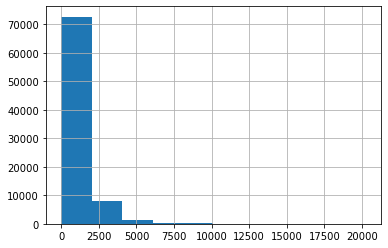

In [66]:
error_abs = abs(predict_grid_lgb - test_Y)
error_abs.hist()

In [67]:
error_abs.describe()

count    83084.000000
mean       992.847692
std       1249.530958
min          0.002630
25%        261.477980
50%        598.448457
75%       1252.975358
max      20239.783183
Name: price, dtype: float64

In [68]:
target = pd.Series(test_Y)
predict = pd.Series(predict_grid_lgb)

Text(0, 0.5, 'частота')

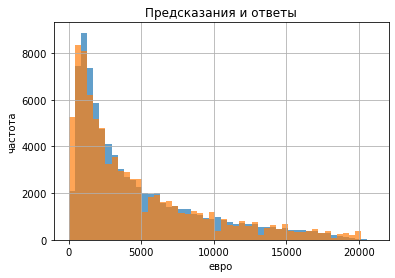

In [69]:
ax = predict.hist(bins=50,range=(0,21000), alpha=0.7) 
target.hist(bins=50, ax=ax, range=(0,21000), alpha=0.7) 
plt.title("Предсказания и ответы")
plt.xlabel("евро")
plt.ylabel("частота")

Медиана меньше среднего, большие редкие значения ошибки влияют на среднее

## Общий вывод 

В ходе проекта была реализована цель построения модели, которая определяет стоимость автомобиля, и выбрана модель с лучшими харктеристиками. 

Для реализации цели были выполнены следующие шаги:

    изучены данные, определены признаки для анализа и целевой признак, заполнены пропуски;
    проведен исследовательский анализ признаков, устранены аномалии;
    данные подготовлены для обучения моделей;
    обучены 3 модели: CatBoostRegressor, LGBMRegressor,LinearRegression;
    определены и расчитаны критерии качества для каждой модели, составлена таблица с основными критериями. 
    
**Лучшей моделью выбрана: LGBMRegressor, как модель с лучшим качеством предсказаний и достаточно высокой скоростью обучения и предсказания.**